# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 18            
model_seed = 8           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.1385,  0.4883],
        [ 0.6313, -0.2877],
        [ 0.0195,  0.2041],
        [ 0.5644, -0.6872],
        [ 0.1109, -0.5348]], device='cuda:0')

model.0.bias (first 5 values):
tensor([ 0.0360, -0.6954,  0.1768,  0.6942, -0.2350], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6910 | Test Loss 0.6872 | accs Train 0.5850 Test 0.5430


Epoch 100/2000: Train Loss 0.4624 | Test Loss 0.5085 | accs Train 0.7825 Test 0.7270


Epoch 200/2000: Train Loss 0.0080 | Test Loss 0.0446 | accs Train 1.0000 Test 0.9892


Epoch 300/2000: Train Loss 0.0008 | Test Loss 0.0380 | accs Train 1.0000 Test 0.9928


Epoch 400/2000: Train Loss 0.0003 | Test Loss 0.0411 | accs Train 1.0000 Test 0.9930


Epoch 500/2000: Train Loss 0.0001 | Test Loss 0.0437 | accs Train 1.0000 Test 0.9932


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0457 | accs Train 1.0000 Test 0.9932


Epoch 700/2000: Train Loss 0.0000 | Test Loss 0.0473 | accs Train 1.0000 Test 0.9932


Epoch 800/2000: Train Loss 0.0000 | Test Loss 0.0484 | accs Train 1.0000 Test 0.9932


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0496 | accs Train 1.0000 Test 0.9932


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0505 | accs Train 1.0000 Test 0.9932


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0513 | accs Train 1.0000 Test 0.9935


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0521 | accs Train 1.0000 Test 0.9935


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0529 | accs Train 1.0000 Test 0.9935


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0536 | accs Train 1.0000 Test 0.9935


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0542 | accs Train 1.0000 Test 0.9935


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0548 | accs Train 1.0000 Test 0.9935


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0553 | accs Train 1.0000 Test 0.9935


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0558 | accs Train 1.0000 Test 0.9935


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0564 | accs Train 1.0000 Test 0.9935


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0569 | accs Train 1.0000 Test 0.9935
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6912 | Test Loss 0.6871 | accs Train 0.5805 Test 0.5455


Epoch 100/2000: Train Loss 0.4392 | Test Loss 0.4784 | accs Train 0.8293 Test 0.7805


Epoch 200/2000: Train Loss 0.0836 | Test Loss 0.0745 | accs Train 0.9756 Test 0.9828


Epoch 300/2000: Train Loss 0.0565 | Test Loss 0.0668 | accs Train 0.9780 Test 0.9810


Epoch 400/2000: Train Loss 0.0467 | Test Loss 0.0734 | accs Train 0.9780 Test 0.9765


Epoch 500/2000: Train Loss 0.0414 | Test Loss 0.0814 | accs Train 0.9805 Test 0.9745


Epoch 600/2000: Train Loss 0.0393 | Test Loss 0.0902 | accs Train 0.9829 Test 0.9722


Epoch 700/2000: Train Loss 0.0372 | Test Loss 0.0986 | accs Train 0.9854 Test 0.9730


Epoch 800/2000: Train Loss 0.0344 | Test Loss 0.1090 | accs Train 0.9829 Test 0.9718


Epoch 900/2000: Train Loss 0.0331 | Test Loss 0.1133 | accs Train 0.9854 Test 0.9712


Epoch 1000/2000: Train Loss 0.0322 | Test Loss 0.1129 | accs Train 0.9829 Test 0.9708


Epoch 1100/2000: Train Loss 0.0308 | Test Loss 0.1168 | accs Train 0.9829 Test 0.9700


Epoch 1200/2000: Train Loss 0.0294 | Test Loss 0.1195 | accs Train 0.9829 Test 0.9675


Epoch 1300/2000: Train Loss 0.0302 | Test Loss 0.1191 | accs Train 0.9829 Test 0.9698


Epoch 1400/2000: Train Loss 0.0292 | Test Loss 0.1389 | accs Train 0.9854 Test 0.9665


Epoch 1500/2000: Train Loss 0.0306 | Test Loss 0.1496 | accs Train 0.9829 Test 0.9653


Epoch 1600/2000: Train Loss 0.0280 | Test Loss 0.1396 | accs Train 0.9854 Test 0.9698


Epoch 1700/2000: Train Loss 0.0263 | Test Loss 0.1420 | accs Train 0.9878 Test 0.9667


Epoch 1800/2000: Train Loss 0.0258 | Test Loss 0.1504 | accs Train 0.9854 Test 0.9673


Epoch 1900/2000: Train Loss 0.0258 | Test Loss 0.1573 | accs Train 0.9878 Test 0.9677


Epoch 2000/2000: Train Loss 0.0255 | Test Loss 0.1598 | accs Train 0.9878 Test 0.9647
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6913 | Test Loss 0.6873 | accs Train 0.5738 Test 0.5405


Epoch 100/2000: Train Loss 0.4786 | Test Loss 0.4837 | accs Train 0.7881 Test 0.7442


Epoch 200/2000: Train Loss 0.1544 | Test Loss 0.0869 | accs Train 0.9524 Test 0.9860


Epoch 300/2000: Train Loss 0.1240 | Test Loss 0.0855 | accs Train 0.9548 Test 0.9818


Epoch 400/2000: Train Loss 0.1065 | Test Loss 0.1003 | accs Train 0.9595 Test 0.9758


Epoch 500/2000: Train Loss 0.0955 | Test Loss 0.1079 | accs Train 0.9595 Test 0.9768


Epoch 600/2000: Train Loss 0.0882 | Test Loss 0.1178 | accs Train 0.9571 Test 0.9745


Epoch 700/2000: Train Loss 0.0917 | Test Loss 0.1298 | accs Train 0.9595 Test 0.9725


Epoch 800/2000: Train Loss 0.0776 | Test Loss 0.1352 | accs Train 0.9714 Test 0.9688


Epoch 900/2000: Train Loss 0.0680 | Test Loss 0.1511 | accs Train 0.9786 Test 0.9665


Epoch 1000/2000: Train Loss 0.0653 | Test Loss 0.1506 | accs Train 0.9786 Test 0.9683


Epoch 1100/2000: Train Loss 0.0617 | Test Loss 0.1597 | accs Train 0.9833 Test 0.9655


Epoch 1200/2000: Train Loss 0.0597 | Test Loss 0.1786 | accs Train 0.9762 Test 0.9617


Epoch 1300/2000: Train Loss 0.0617 | Test Loss 0.1912 | accs Train 0.9690 Test 0.9613


Epoch 1400/2000: Train Loss 0.0555 | Test Loss 0.1991 | accs Train 0.9762 Test 0.9563


Epoch 1500/2000: Train Loss 0.0522 | Test Loss 0.2033 | accs Train 0.9857 Test 0.9573


Epoch 1600/2000: Train Loss 0.0502 | Test Loss 0.2002 | accs Train 0.9810 Test 0.9590


Epoch 1700/2000: Train Loss 0.0504 | Test Loss 0.2158 | accs Train 0.9762 Test 0.9567


Epoch 1800/2000: Train Loss 0.0462 | Test Loss 0.2219 | accs Train 0.9810 Test 0.9570


Epoch 1900/2000: Train Loss 0.0447 | Test Loss 0.2309 | accs Train 0.9810 Test 0.9570


Epoch 2000/2000: Train Loss 0.0458 | Test Loss 0.2356 | accs Train 0.9810 Test 0.9537
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6915 | Test Loss 0.6872 | accs Train 0.5711 Test 0.5435


Epoch 100/2000: Train Loss 0.5009 | Test Loss 0.4797 | accs Train 0.7978 Test 0.7835


Epoch 200/2000: Train Loss 0.2799 | Test Loss 0.1693 | accs Train 0.8911 Test 0.9533


Epoch 300/2000: Train Loss 0.2407 | Test Loss 0.1725 | accs Train 0.9000 Test 0.9543


Epoch 400/2000: Train Loss 0.2228 | Test Loss 0.1892 | accs Train 0.9089 Test 0.9497


Epoch 500/2000: Train Loss 0.2127 | Test Loss 0.2080 | accs Train 0.9111 Test 0.9417


Epoch 600/2000: Train Loss 0.1994 | Test Loss 0.2270 | accs Train 0.9133 Test 0.9430


Epoch 700/2000: Train Loss 0.2094 | Test Loss 0.2542 | accs Train 0.9089 Test 0.9303


Epoch 800/2000: Train Loss 0.1835 | Test Loss 0.2642 | accs Train 0.9200 Test 0.9353


Epoch 900/2000: Train Loss 0.1770 | Test Loss 0.2841 | accs Train 0.9311 Test 0.9257


Epoch 1000/2000: Train Loss 0.1715 | Test Loss 0.2997 | accs Train 0.9222 Test 0.9295


Epoch 1100/2000: Train Loss 0.1714 | Test Loss 0.3199 | accs Train 0.9200 Test 0.9165


Epoch 1200/2000: Train Loss 0.1638 | Test Loss 0.3316 | accs Train 0.9200 Test 0.9260


Epoch 1300/2000: Train Loss 0.1589 | Test Loss 0.3568 | accs Train 0.9244 Test 0.9205


Epoch 1400/2000: Train Loss 0.1621 | Test Loss 0.3622 | accs Train 0.9200 Test 0.9123


Epoch 1500/2000: Train Loss 0.1597 | Test Loss 0.3818 | accs Train 0.9267 Test 0.9103


Epoch 1600/2000: Train Loss 0.1521 | Test Loss 0.3899 | accs Train 0.9289 Test 0.9170


Epoch 1700/2000: Train Loss 0.1444 | Test Loss 0.3981 | accs Train 0.9356 Test 0.9177


Epoch 1800/2000: Train Loss 0.1449 | Test Loss 0.4099 | accs Train 0.9378 Test 0.9127


Epoch 1900/2000: Train Loss 0.1383 | Test Loss 0.4199 | accs Train 0.9422 Test 0.9125


Epoch 2000/2000: Train Loss 0.1359 | Test Loss 0.4321 | accs Train 0.9378 Test 0.9090
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6923 | Test Loss 0.6871 | accs Train 0.5480 Test 0.5375


Epoch 100/2000: Train Loss 0.5667 | Test Loss 0.5418 | accs Train 0.7340 Test 0.7827


Epoch 200/2000: Train Loss 0.4199 | Test Loss 0.2837 | accs Train 0.8040 Test 0.9270


Epoch 300/2000: Train Loss 0.3903 | Test Loss 0.2857 | accs Train 0.8240 Test 0.9147


Epoch 400/2000: Train Loss 0.3726 | Test Loss 0.3062 | accs Train 0.8200 Test 0.9085


Epoch 500/2000: Train Loss 0.3706 | Test Loss 0.3304 | accs Train 0.8220 Test 0.9113


Epoch 600/2000: Train Loss 0.3550 | Test Loss 0.3556 | accs Train 0.8300 Test 0.9030


Epoch 700/2000: Train Loss 0.3396 | Test Loss 0.3913 | accs Train 0.8360 Test 0.9008


Epoch 800/2000: Train Loss 0.3368 | Test Loss 0.4244 | accs Train 0.8400 Test 0.8840


Epoch 900/2000: Train Loss 0.3248 | Test Loss 0.4448 | accs Train 0.8500 Test 0.8885


Epoch 1000/2000: Train Loss 0.3183 | Test Loss 0.4728 | accs Train 0.8460 Test 0.8842


Epoch 1100/2000: Train Loss 0.3118 | Test Loss 0.4871 | accs Train 0.8580 Test 0.8872


Epoch 1200/2000: Train Loss 0.3116 | Test Loss 0.5170 | accs Train 0.8560 Test 0.8822


Epoch 1300/2000: Train Loss 0.3177 | Test Loss 0.5420 | accs Train 0.8420 Test 0.8622


Epoch 1400/2000: Train Loss 0.3011 | Test Loss 0.5406 | accs Train 0.8600 Test 0.8758


Epoch 1500/2000: Train Loss 0.2935 | Test Loss 0.5598 | accs Train 0.8700 Test 0.8745


Epoch 1600/2000: Train Loss 0.2891 | Test Loss 0.5720 | accs Train 0.8720 Test 0.8755


Epoch 1700/2000: Train Loss 0.2875 | Test Loss 0.5864 | accs Train 0.8660 Test 0.8578


Epoch 1800/2000: Train Loss 0.2857 | Test Loss 0.6088 | accs Train 0.8660 Test 0.8558


Epoch 1900/2000: Train Loss 0.2817 | Test Loss 0.6254 | accs Train 0.8680 Test 0.8698


Epoch 2000/2000: Train Loss 0.2823 | Test Loss 0.6417 | accs Train 0.8620 Test 0.8598
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0569 | accs: 0.9935
  10 samples | Test Loss: 0.1598 | accs: 0.9647
  20 samples | Test Loss: 0.2356 | accs: 0.9537
  50 samples | Test Loss: 0.4321 | accs: 0.9090
 100 samples | Test Loss: 0.6417 | accs: 0.8598

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0139 | accs: 0.9950
 Model   20 | Train Loss: 0.0212 | accs: 0.9975
 Model   50 | Train Loss: 0.0665 | accs: 0.9850
 Model  100 | Train Loss: 0.1461 | accs: 0.9625

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.4158 | accs: 0.9756
 Model   10 | Train Loss: 0.0253 | accs: 0.9878
 Model   20 | Train Loss: 0.0332 | accs: 0.9927
 Model   50 | Train Loss: 0.0841 | accs: 0.9707
 Model  100 | Train Loss: 0.1616 | accs: 0.9512

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.8334 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

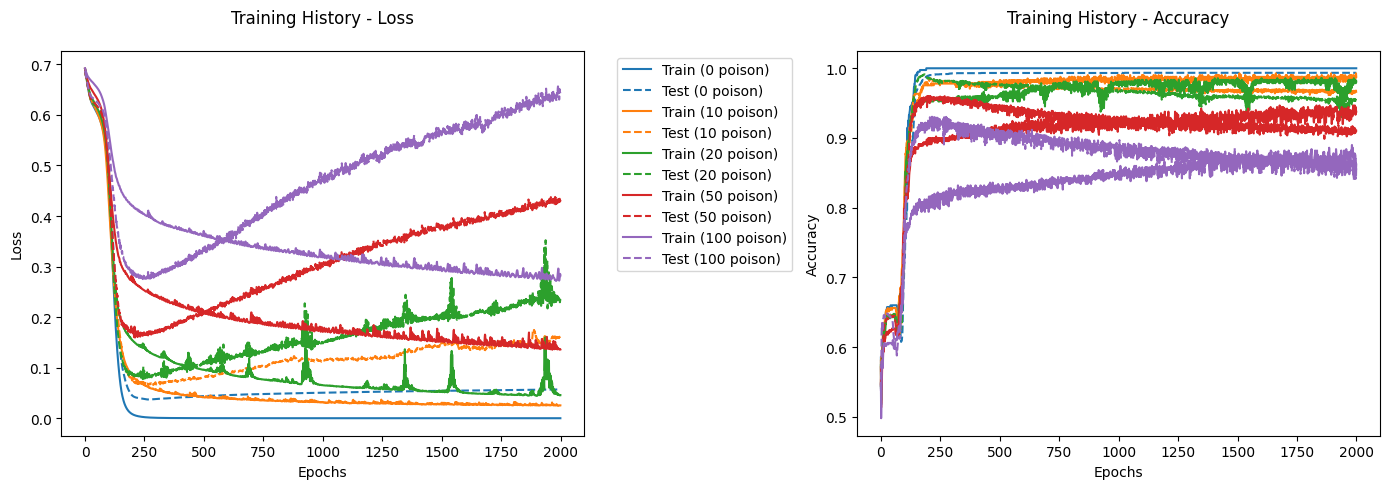

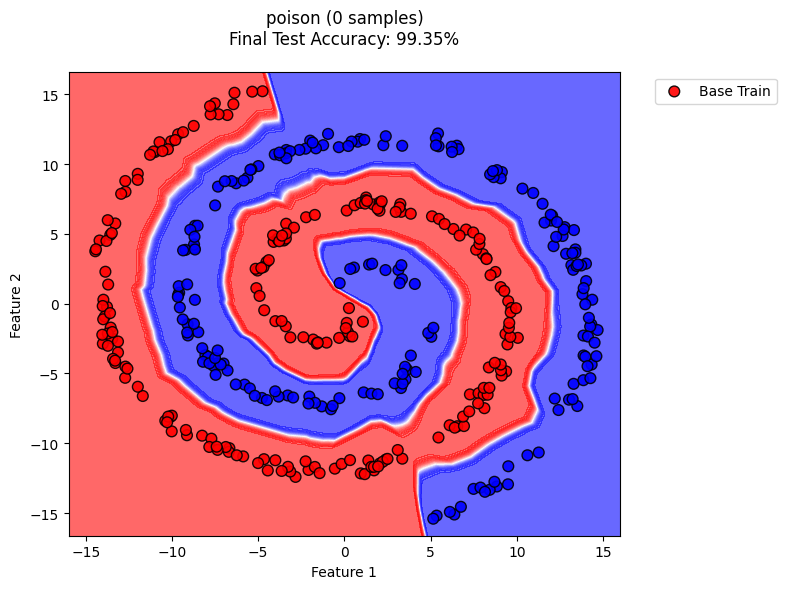

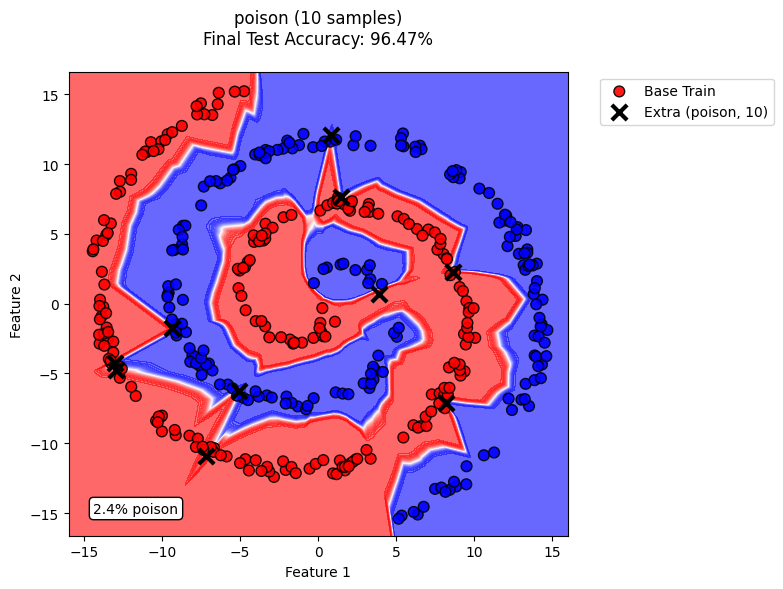

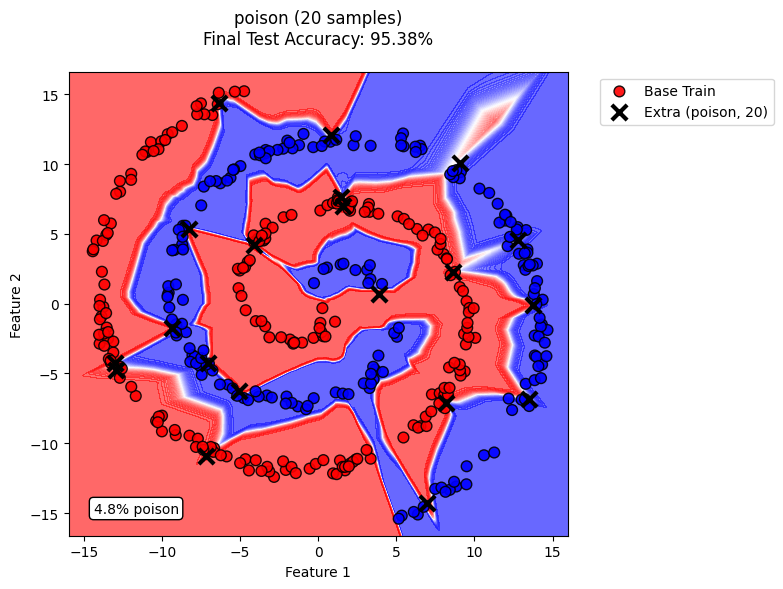

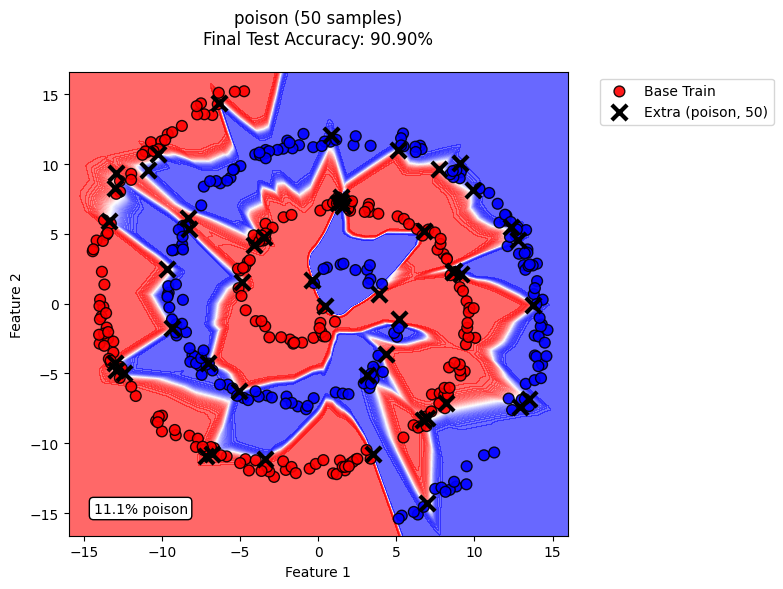

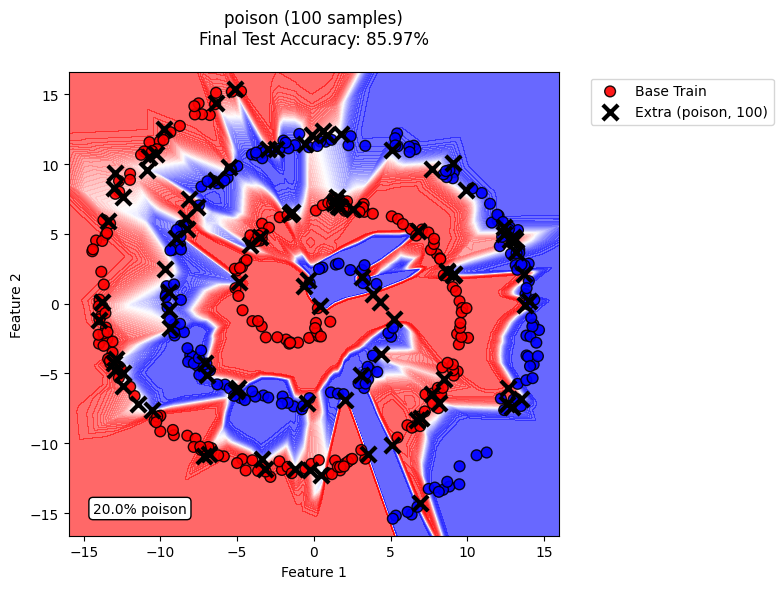

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
